# BMI/CS 576 Fall 2023 - HW3
The objectives of this homework are to practice with

* multiple sequence alignment
* UPGMA
* alignment statistics

## HW policies
Before starting this homework, please read over the [homework policies](https://canvas.wisc.edu/courses/374201/pages/hw-policies) for this course.  In particular, note that homeworks are to be completed *individually* and plagiarism from any source (with the one exception noted below) will be considered **academic misconduct**.

You are welcome to use any code from the weekly notebooks (including the official solutions) in your solutions to the HW.

In [1]:
import fasta
import submatrix
import align
from matplotlib import pyplot as plt

In [2]:
from PIL import Image

## PROBLEM 1: Star alignment (30 points)

In this problem you will implement the [star alignment strategy](https://canvas.wisc.edu/courses/374201/pages/day-12-online-lecture-sequence-alignment-star-multiple-alignment) for multiple sequence alignment.  Implement this strategy as a function `align_star` below, which takes as input a list of sequences, the index of the sequence in this list that should serve as the center, and a substitution matrix (which will also contain the space score within it).  The function should return a multiple sequence alignment represented as a list of aligned sequence strings, in the same order as the input sequences. See the "Tests for PROBLEM 1" section at the bottom of this notebook for examples of the inputs and outputs. 

### Implementation details

1. Your function should call the `align_global` function provided in the included `align` module to construct a pairwise alignment between each sequence and the center sequence.  When calling this function, use the center sequence as `y`, the **second sequence** provided to the function (this will be important when there are ties in the optimal pairwise alignment).  Also, note that `align_global` is the function provided in the Day 12 notebook and is designed to align two *alignments*.  To align two sequences, simply place each sequence in its own list.

2. In between columns of the multiple alignment that contain a character from the center sequence, i.e. where there are insertions with respect to the center sequence, the columns should be ordered such that the columns for the inserted characters for sequence $i$ come before the columns for the inserted characters for sequence $j$ if $i < j$.  For example, in the star alignment of the sequences CTTAT, CAAAT, CGGAT, CAT (in that order), with the last sequence (CAT) as the center, the optimal pairwise alignments and star alignment resulting from this criterion are:

        pairwise alignments:

        CTTAT   CAAAT   CGGAT
        C--AT   C--AT   C--AT
    
        star alignment:
    
        CTT----AT
        C--AA--AT
        C----GGAT
        C------AT

### Algorithm

There are many ways to implement this function and you are free to chose an approach that is most intuitive to you.  The lecture suggests one approach, in which you start with one of the pairwise alignments, and then merge in each additional alignment one by one.  

You can also build the multiple alignment by simultaneously traversing the pairwise alignments from left to right.  Here is an informal and brief description of such an approach:  
* Build the alignment column by column, using a list to hold the columns you have constructed thus far. 
* Using a list, keep track of the position (column number) that you are currently at within each pairwise alignment (initially, you will be off of the front of each alignment).  
* On each iteration, loop through each pairwise alignment in order (i.e., starting with the pairwise alignment of the first sequence with the center) and increment the position within that alignment until you reach a column in which the center sequence has a character (i.e., not a '-').  If during this process you passed through any columns in which there were inserted characters in the non-center sequence, add columns to the multiple alignment for each of these inserted characters (gapped against all other sequences).  
* After you have looped through all pairwise alignments, the positions within each pairwise alignment should all be at the same character within the center sequence.  Add a column to the multiple alignment corresponding to the alignment of this center sequence character with the characters or spaces it is aligned to in the pairwise alignments.  
* Repeat this process (starting by looping through each pairwise alignment again) until you fall off the end of all of the pairwise alignments.

### Substitution matrices

In [3]:
# Here will set up some of the substitution matrices used in this homework
DNA = "ACGT"

# A simple match=+1 and mismatch=-1 substitution matrix for DNA
basic_dna_submatrix = submatrix.match_mismatch_matrix(1, -1, DNA)

# Simple DNA matrix with space score = -1
basic_dna_s1 = submatrix.submatrix_with_spaces(basic_dna_submatrix, -1)

print("basic_dna_s1:")
submatrix.print_matrix(basic_dna_s1)
print()

# The BLOSUM62 amino acid substitution matrix
blosum62 = submatrix.read_substitution_matrix("BLOSUM62.txt")

blosum62_with_spaces = submatrix.submatrix_with_spaces(blosum62, -2)

basic_dna_s1:
       -   A   C   G   T
   -   0  -1  -1  -1  -1
   A  -1   1  -1  -1  -1
   C  -1  -1   1  -1  -1
   G  -1  -1  -1   1  -1
   T  -1  -1  -1  -1   1



In [4]:
def align_star(sequences, center_index, substitution_matrix):
    """Computes a multiple alignment with the star alignment strategy
    using the specified sequence as the center.
    
    Args:
        sequences: a list of strings
        center_index: The index of the sequence in sequences to use as the center.
        substitution_matrix: a substitution matrix, represented as a dictionary, with
                             space scores included.

    Returns:
        A multiple alignment, represented by a list of aligned strings.
    """
    print(sequences)
    y = [sequences[center_index]]
    main = len(sequences[center_index])
    # ans = [s for s in sequences]
    
    finda = []
    for i, seq in enumerate(sequences):
        a = align.align_global([seq], y, substitution_matrix)
        finda.append([a[0],a[1]])
                      
    print(finda)
    position = [-1] * len(sequences)
    ans = []
    while all(position[p] < len(finda[p][1]) for p in range(len(finda))):
        for i in range(len(finda)):
            while (True):
                alignment = []
                position[i] += 1
                if position[i] >= len(finda[i][1]):
                    break
                elif finda[i][1][position[i]] == '-':
                    for append in range(len(finda)):
                        if append == i:
                            alignment.append(finda[i][0][position[i]])
                        else:
                            alignment.append('-')
                    ans.append(alignment)
                    # print(alignment)
                else:
                    break
                    
        for j in range(len(finda)):
            if position[j] >= len(finda[j][1]):
                break
            else:
                alignment.append(finda[j][0][position[j]])
                if alignment in ans:
                    continue
                else:
                    ans.append(alignment)
        # print(alignment)
    ans = align.transpose_alignment(ans)
    print("ANS",ans)

    return ans

Tests for Problem 1 are found at the bottom of this notebook.

## PROBLEM 2: Star alignment of SARS-CoV-2 spike proteins (20 points)
The spike protein encoded by the SARS-CoV-2 genome is one of most interesting features of the virus, as it is responsible for the binding of the viral capsid to host cells.  Included with this notebook is the file `spike_proteins.fasta`, which contains the sequences of this protein from multiple variants of the virus.  In this problem, we will create a multiple alignment of these protein sequences and analyze the result to gain insights as to how it has evolved.

**(a)** Compute a pairwise distance matrix for these protein sequences using the `pairwise_edit_distances` function provided in the `align` module and the `blosum62_with_spaces` substitution matrix defined above.  Use the resulting matrix to identify a sequence with the *minimum* sum of pairwise distances to all other sequences.  Show your work and give the name (variant) of the identified sequence.

**(b)** Compute a multiple alignment of the sequences using your `align_star` function using the sequence you identified in part (a) as the center sequence and the `blosum62_with_spaces` substitution matrix.  If you are unable to implement `align_star`, you may use the `align_progressive` function from the Day 12 notebook instead.

**(c)** Compute the number of pairwise edits (substitution or insertion/deletion) within each column of this multiple alignment (consider using `num_edits_in_column` function provided in the `align` module for this).  Plot the number of pairwise edits at each column of the alignment (a scatter plot with x = column index and y = number of pairwise edits at column x).

**(d)** Shown below is a diagram of the different domains of the spike protein taken from [Huang et al. 2020](http://dx.doi.org/10.1038/s41401-020-0485-4).  The domains are the N-terminal domain (NTD), receptor-binding domain (RBD), fusion peptide (FP), heptapeptide repeat sequence 1 (HR1), heptapeptide repeat sequence 2 (HR2), transmembrane domain (TM), and cytoplasm domain (CT).  Compare your plot from part (b) to this diagram (note: the relative widths of the domains in this diagram are not proportional to their actual lengths, unfortunately).  Which domain appears to be evolving most rapidly?  Explain your answer.
![spike_domains](spike_domains.png)

### 2a

In [5]:
def readFasta(file):
    s = []
    with open(file,'r') as f:
        current = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current == "":
                    continue
                else:
                    s.append(current)
                    current = ""
            else:
                current += line
        s.append(current)
    return s

spike = readFasta("spike_proteins.fasta")

In [6]:
###
### (a)
###

parta = align.pairwise_edit_distances(spike, blosum62_with_spaces)
parta

[[0, 17, 18, 37, 35, 46],
 [17, 0, 20, 45, 37, 48],
 [18, 20, 0, 44, 37, 46],
 [37, 45, 44, 0, 29, 39],
 [35, 37, 37, 29, 0, 20],
 [46, 48, 46, 39, 20, 0]]

### 2b

In [7]:
###
### (b)
###
for i in parta:
    print(sum(i))
    #first one is the most smallest one
spikeAlign = align_star(spike, 0, blosum62_with_spaces)

153
167
165
194
158
199
['MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAISGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIDDTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPINFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVL

### 2c

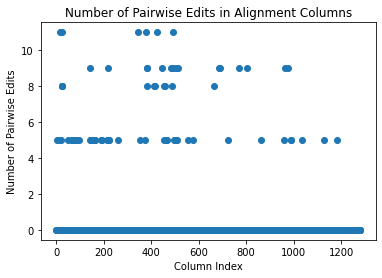

In [8]:
###
### (c)
###
column = []
for i in range(len(spikeAlign[0])):  # Assuming all sequences have the same length
    s = [seq[i] for seq in spikeAlign] 
    col = align.num_edits_in_column(s)
    column.append(col)

plt.scatter(range(len(column)), column)
plt.xlabel("Column Index")
plt.ylabel("Number of Pairwise Edits")
plt.title("Number of Pairwise Edits in Alignment Columns")
plt.show()

### 2d

### (D)
In the plot, if a specific column (representing a position in the protein sequence) has low pairwise edit distances, it indicates that this position is more conserved among different variants of the protein. On the other hand, if a column has high number of pairwise edit, it means that this position is more variable among variants.

In the graph generated in part (c), you noticed that the region with the highest and most pairwise edits falls between positions 300 and 500. This corresponds to the Receptor-Binding Domain (RBD). Therefore, it suggests that the RBD is evolving most rapidly among different variants of the protein.

###
### Your solution to Problem 2d here
###


## PROBLEM 3: UPGMA (25 points)

Construct a tree from the distance matrix below using the UPGMA algorithm. Show your updated distance matrix and intermediate tree(s) after each merge.  Give branch lengths for your intermediate and final trees.

|       | A | B | C | D | E | F |
|-------|---|---|---|---|---|---|
| **A** |   | 8 | 10|  8| 10| 4 |
| **B** |   |   | 10|  6| 10| 8 |
| **C** |   |   |   | 10|  2| 10|
| **D** |   |   |   |   | 10| 8 |
| **E** |   |   |   |   |   | 10|
| **F** |   |   |   |   |  &nbsp;

###
### Your solution to Problem 3 here
###


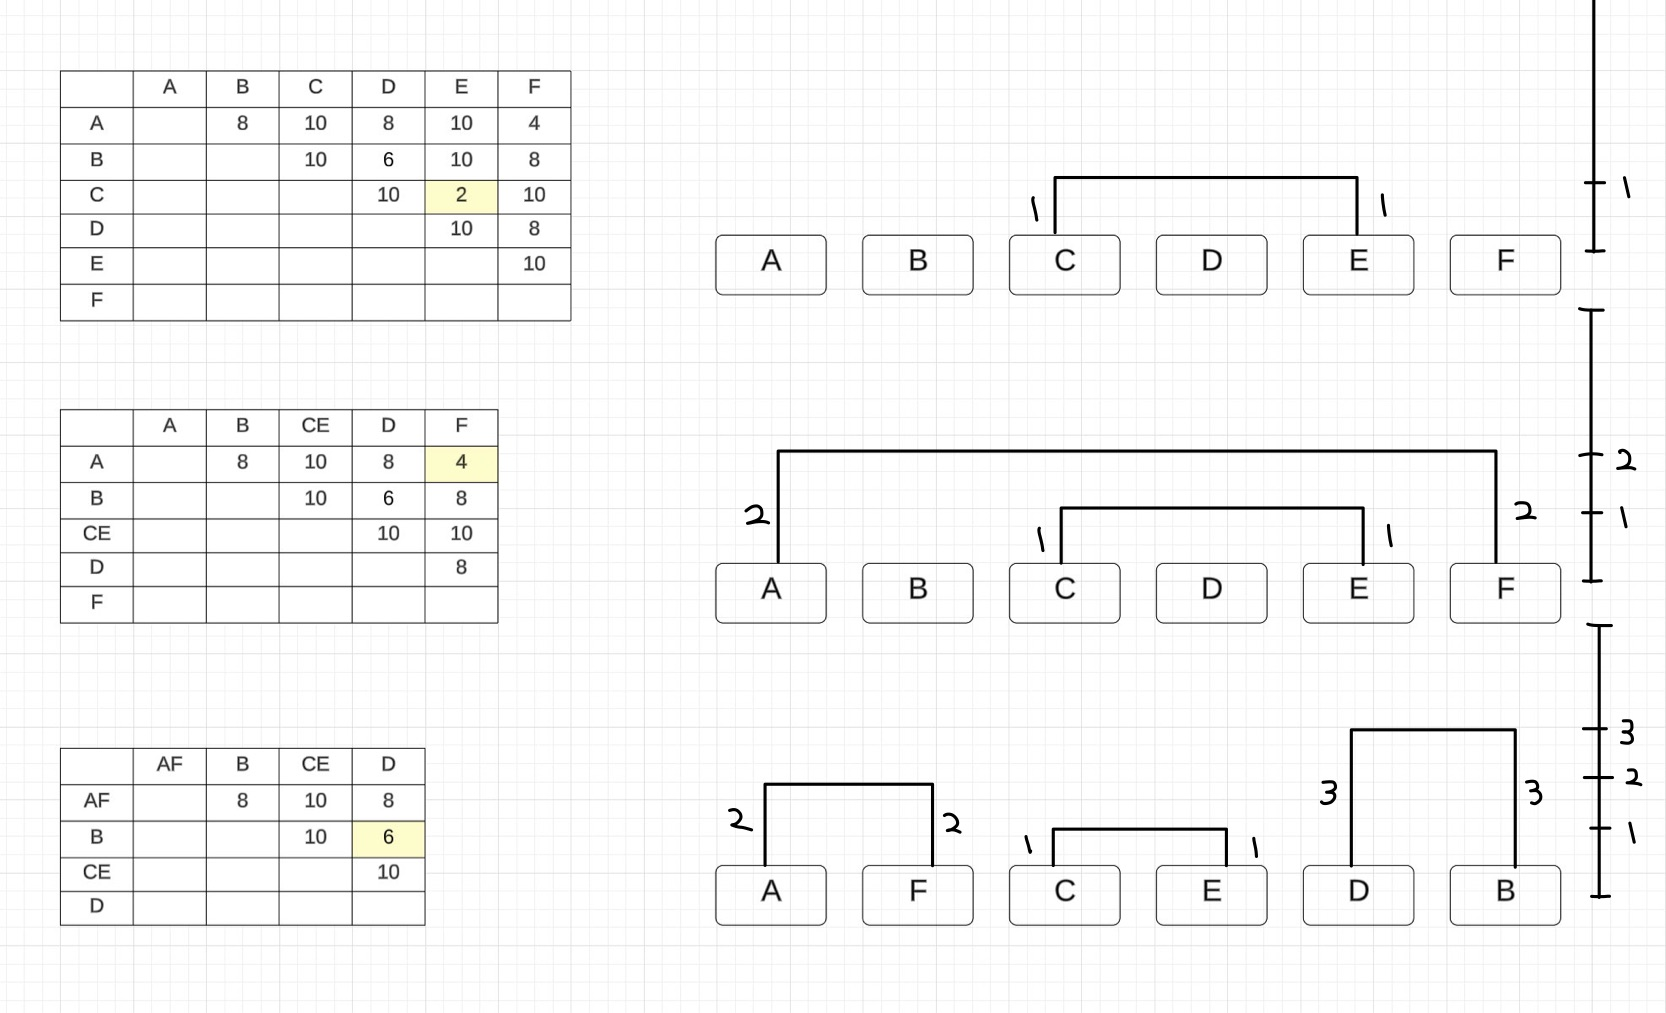

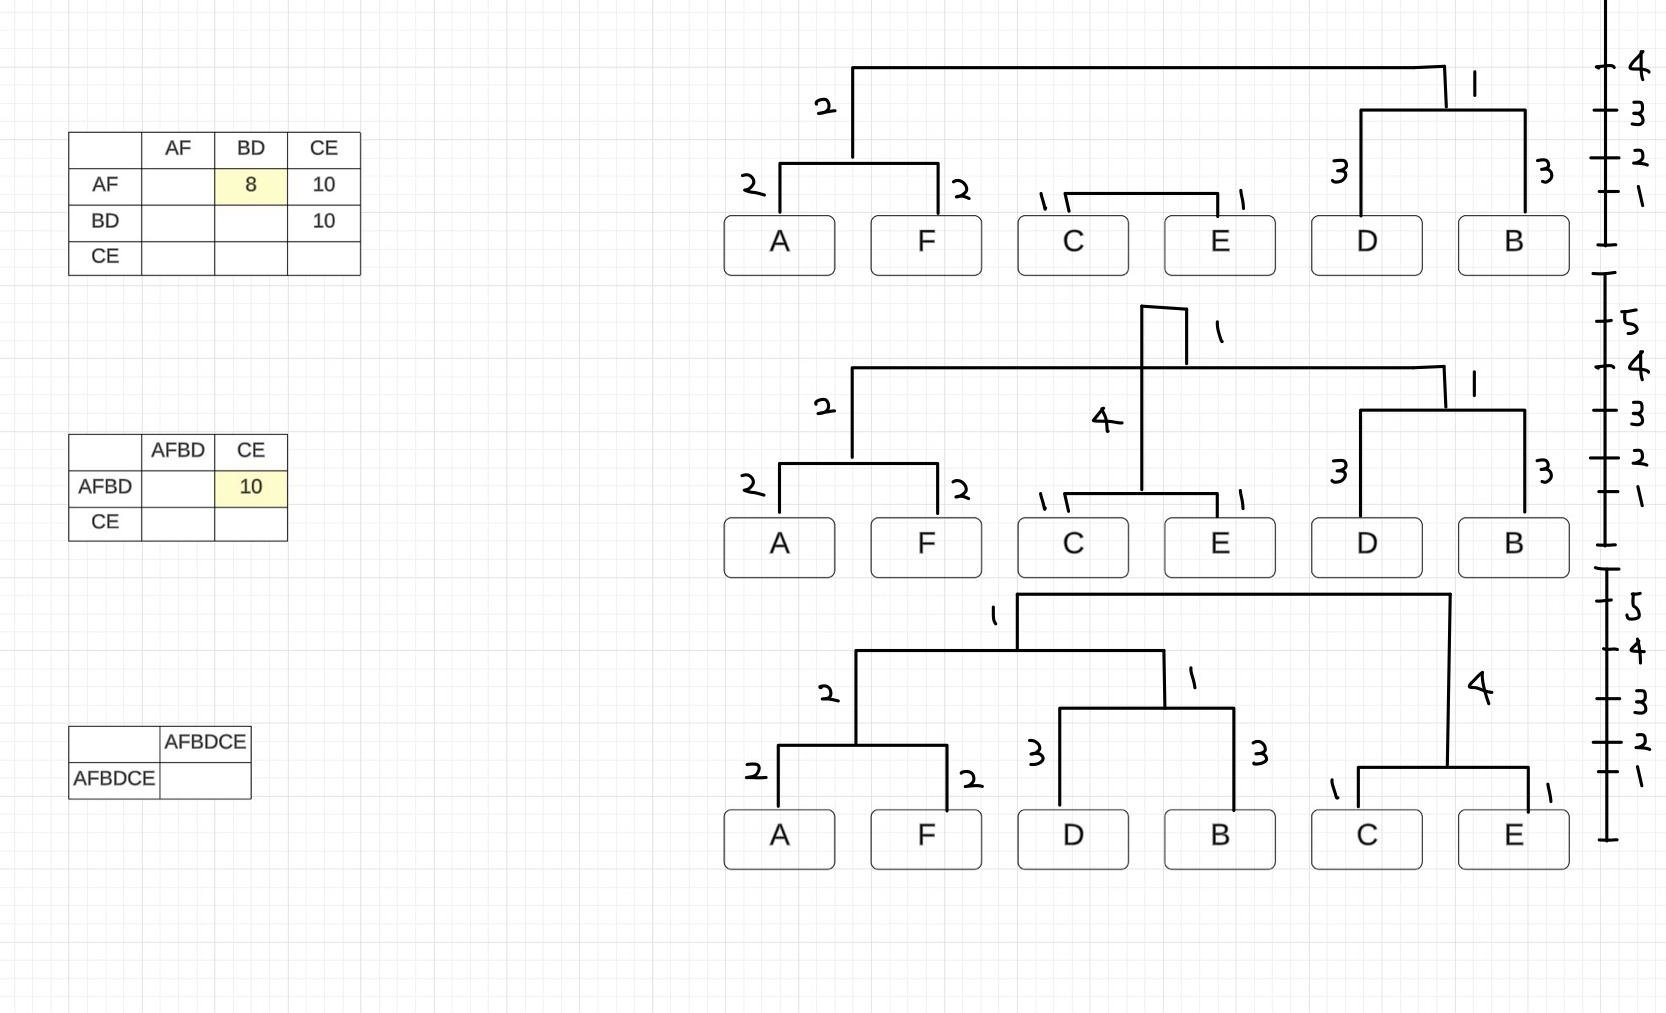

In [9]:
img = Image.open("upgma1.jpg")
img2 = Image.open("upgma2.jpg")
display(img, img2)

## PROBLEM 4: Alignment statistics (25 points)

Suppose a researcher is interested in a particular protein X and searches a protein sequence database with BLAST to find proteins similar to X. *Show your work* for each of the following questions.

**(a)** The researcher is excited to find an alignment of X to a protein Y in the database that has score $S = 84$.  Given that the length of X is $m = 200$ amino acids and that the total length of the database is $n = 2\times 10^9$ amino acids, what is the *expected number* of alignments that one would find with score $> S$ assuming that the sequences in the database are unrelated to X?  Use the parameter values $K = 0.041$ and $\lambda = 0.267$.

**(b)** For the same scenario in (a), what is the *probability*, $p$, of finding at least one alignment with score $> S$?

**(c)** Assuming the same lengths and parameter values given in (a), for what value of $S$ will $p = 0.05$?

**(d)** To increase the chances of finding a significant alignment in the database, the researcher attempts to search the database with X and five other proteins *highly-similar* to X (e.g., the spike proteins in problem 2).  Let $C_i$ be the random variable representing the number of alignments found for query protein $i$ (where $1 \leq i \leq 6$) with score $> 84$. Are the $C_i$ random variables independent of each other?  That is, is $C_i$ independent of $C_j$ for $i \neq j$?  Explain your answer.

**(e)** For the scenario in (d), what is the expected total number of alignments found with score $> 84$ across all queries?  That is, what is $E\left[\sum_{i=1}^{6} C_i\right]$?  Assume that all of the query proteins have the same length $m = 200$.

### (A) E=Kmnexp(−λS)
E = $0.041 × 200 × 2×10^9 exp(-0.267 * 84) ≈0.041× 200 × 2×10^9 exp(−22.428)≈0.041×200 ×2×10^9 ×1.8182 ×10^-10≈ 2.9818$

### (B) p=1−exp(−E)
p = $ 1 - exp(-E) = 1 - exp(-2.9818) ≈ 1 - 0.0507 ≈ 0.9493$


### (C) p=0.05?
$0.05 = 1 - exp(-E)$, which means that $ -E ≈ ln(0.95)$ -> E $≈ -ln(0.95)$

$E = Kmnexp(−λS) ≈ -ln(0.95) ≈ 0.041 × 200 × 2×10^9 exp(-0.267 × S) ≈ 16.4 × 10^9 exp(-0.267 × S)$

$-ln(0.95) ÷ (16.4 ×10^9) ≈ exp(-0.267 × S)$

$ln(3.1276 × 10^-12) ≈ -26.4907 ≈ -0.267 × S $

$S ≈ -26.4907 ÷ -0.267 ≈ 99.2161$

$S ≈ 100$

### (D)
The fact that the database with X and five other highly similar proteins implies that these proteins share significant sequence similarity and are likely to produce similar results in the database. In such a case, the Ci random variables are not independent because the outcome of one query can affect the outcomes of the others.

### (E) E[Σ6𝑖=1𝐶𝑖]
$E[Σ6𝑖=1𝐶𝑖] = Σ6𝑖=1 × E[Ci]$

$E[Σ6𝑖=1𝐶𝑖] ≈ Σ6𝑖=1 × 2.9818 ≈ 6 × 2.9818$

$E[Σ6𝑖=1𝐶𝑖] ≈ 17.8908$

###
### Your solution to Problem 4 here
###


## Tests for Problem 1

In [10]:
test_case_inputs = {
    'tiny':    (["CAT", "CT", "CAGT"],              0, basic_dna_s1),
    'pair':    (["TAC", "ATC"],                     0, basic_dna_s1),
    'quiz0':   (["ATGC", "CTGA", "TGCTG"],          0, basic_dna_s1),
    'quiz1':   (["ATGC", "CTGA", "TGCTG"],          1, basic_dna_s1),
    'quiz2':   (["ATGC", "CTGA", "TGCTG"],          2, basic_dna_s1),
    'example': (["CTTAT", "CAAAT", "CGGAT", "CAT"], 3, basic_dna_s1),
    'protein': (['ACQTC', 'LSMVL', 'HPVFF', 'RPEAG', 'SGGPM'], 4, blosum62_with_spaces),
    'large':   (['TTGGACTGTT', 'GTGTCTCTGT', 'GCTTGGCTTG', 'TAAGGCACCG', 'GCTCACTAGC'], 3, basic_dna_s1)
}

test_case_correct_outputs = {
    'tiny':    ["CA-T", 
                "C--T", 
                "CAGT"],
    'pair':    ["TA-C",
                "-ATC"],
    'quiz0':   ["ATGC--", 
                "CTGA--", 
                "-TGCTG"],
    'quiz1':   ["--ATGC",
                "--CTGA",
                "TGCTG-"],
    'quiz2':   ["ATGC---",
                "---CTGA",
                "-TGCTG-"],
    'example': ["CTT----AT",
                "C--AA--AT",
                "C----GGAT",
                "C------AT"],
    'protein': ["---ACQTC--",
                "L--S-MVL--",
                "---H--PVFF",
                "-RPEAG----",
                "---SGGPM--"],
    'large':   ["---T-TG-G-AC-TGTT--",
                "G--T--G-TCTC-TG--T-",
                "-GCT-TG-GC-T-TG----",
                "---TAAG-GCAC-CG----",
                "------GCTCACTAG---C"]
}

import numbers
import io
import sys

def remove_gaps(s):
    """Returns a string with '-' characters removed"""
    return s.replace('-', '')

def check_valid_alignment(alignment, sequences, center_index):
    """Checks that the alignment result is valid for x and g.""" 
    assert isinstance(alignment, list), "Alignment is not a list"
    assert len(alignment) == len(sequences), "Alignment does not have number of rows equal to the number of sequences"
    
    assert all(isinstance(element, str) for element in alignment), "Alignment elements are not strings"
    num_columns = len(alignment[0])
    assert all(len(row) == num_columns for row in alignment), "Alignment strings do not have the same length"
    
    for i, seq in enumerate(sequences):
        assert remove_gaps(alignment[i]) == seq, f"The {i}th row does not match the {i}th sequence"

def check_test_case(case_name, test_name=None, valid_result=True, correct_alignment=True):
    inputs = test_case_inputs[case_name]
    correct_output = test_case_correct_outputs[case_name]
    result = align_star(*inputs)
    if valid_result:
        check_valid_alignment(result, *inputs[:2])
    if correct_alignment:
        error_message = io.StringIO()
        print("Incorrect output", file=error_message)
        print("your function returned:", file=error_message)
        pprint_multiple_alignment(result, stream=error_message)
        print(file=error_message)
        print("the correct output is:", file=error_message)
        pprint_multiple_alignment(correct_output, stream=error_message)
        assert result == correct_output, error_message.getvalue()

    print("SUCCESS:", test_name if test_name else case_name, "passed!")

def pprint_multiple_alignment(alignment, stream=sys.stdout):
    """Pretty prints a multiple alignment.
    
    Args:
        alignment: a multiple alignment
        stream: the stream (a file-like object) to which to print
    """
    for i, row in enumerate(alignment):
        print(f"       {i}: {row}", file=stream)

### Visible tests (24 points total)

In [11]:
# TEST: tiny valid output (5 POINTS)
check_test_case("tiny", test_name="tiny valid output", valid_result=True, correct_alignment=False)

['CAT', 'CT', 'CAGT']
[['CAT', 'CAT'], ['C-T', 'CAT'], ['CAGT', 'CA-T']]
ANS ['CA-T', 'C--T', 'CAGT']
SUCCESS: tiny valid output passed!


In [12]:
# TEST: tiny correct (5 POINTS)
check_test_case("tiny", test_name="tiny_correct", valid_result=True, correct_alignment=True)

['CAT', 'CT', 'CAGT']
[['CAT', 'CAT'], ['C-T', 'CAT'], ['CAGT', 'CA-T']]
ANS ['CA-T', 'C--T', 'CAGT']
SUCCESS: tiny_correct passed!


In [13]:
# TEST: pair (2 POINTS)
check_test_case("pair")

['TAC', 'ATC']
[['TAC', 'TAC'], ['-ATC', 'TA-C']]
ANS ['TA-C', '-ATC']
SUCCESS: pair passed!


In [14]:
# TEST: quiz0 (2 POINTS)
check_test_case("quiz0")

['ATGC', 'CTGA', 'TGCTG']
[['ATGC', 'ATGC'], ['CTGA', 'ATGC'], ['-TGCTG', 'ATGC--']]
ANS ['ATGC--', 'CTGA--', '-TGCTG']
SUCCESS: quiz0 passed!


In [15]:
# TEST: quiz1 (2 POINTS)
check_test_case("quiz1")

['ATGC', 'CTGA', 'TGCTG']
[['ATGC', 'CTGA'], ['CTGA', 'CTGA'], ['TGCTG-', '--CTGA']]
ANS ['--ATGC', '--CTGA', 'TGCTG-']
SUCCESS: quiz1 passed!


In [16]:
# TEST: quiz2 (2 POINTS)
check_test_case("quiz2")

['ATGC', 'CTGA', 'TGCTG']
[['ATGC--', '-TGCTG'], ['--CTGA', 'TGCTG-'], ['TGCTG', 'TGCTG']]
ANS ['ATGC---', '---CTGA', '-TGCTG-']
SUCCESS: quiz2 passed!


In [17]:
# TEST: example (2 POINTS)
check_test_case("example")

['CTTAT', 'CAAAT', 'CGGAT', 'CAT']
[['CTTAT', 'C--AT'], ['CAAAT', 'C--AT'], ['CGGAT', 'C--AT'], ['CAT', 'CAT']]
ANS ['CTT----AT', 'C--AA--AT', 'C----GGAT', 'C------AT']
SUCCESS: example passed!


In [18]:
# TEST: protein (2 POINTS)
check_test_case("protein")

['ACQTC', 'LSMVL', 'HPVFF', 'RPEAG', 'SGGPM']
[['ACQTC', 'SGGPM'], ['LS-MVL', '-SGGPM'], ['H--PVFF', 'SGGPM--'], ['RPEAG--', '--SGGPM'], ['SGGPM', 'SGGPM']]
ANS ['---ACQTC--', 'L--S-MVL--', '---H--PVFF', '-RPEAG----', '---SGGPM--']
SUCCESS: protein passed!


In [19]:
# TEST: large (2 POINTS)
check_test_case("large")

['TTGGACTGTT', 'GTGTCTCTGT', 'GCTTGGCTTG', 'TAAGGCACCG', 'GCTCACTAGC']
[['T-TGG-ACTGTT', 'TAAGGCACCG--'], ['GT--GTCTCTGT', '-TAAGGCACCG-'], ['GCT-TGGC-TTG', '--TAAGGCACCG'], ['TAAGGCACCG', 'TAAGGCACCG'], ['---GCTCACTAGC', 'TAAG-GCAC-CG-']]
ANS ['---T-TG-G-AC-TGTT--', 'G--T--G-TCTC-TG--T-', '-GCT-TG-GC-T-TG----', '---TAAG-GCAC-CG----', '------GCTCACTAG---C']
SUCCESS: large passed!


### Hidden tests (6 points total)

In [20]:
# TEST: hidden_1 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [21]:
# TEST: hidden_2 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [22]:
# TEST: hidden_3 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###
